Image Name: tennis_court0.jpg, Canny Threshold 0: 866, Canny Threshold 1: 290, Number of Lines: 33, Homography Error: 41.9
Image Name: tennis_court0.jpg, Canny Threshold 0: 874, Canny Threshold 1: 282, Number of Lines: 31, Homography Error: 31.5
Image Name: tennis_court0.jpg, Canny Threshold 0: 888, Canny Threshold 1: 278, Number of Lines: 37, Homography Error: 12.1
Image Name: tennis_court1.jpg, Canny Threshold 0: 864, Canny Threshold 1: 302, Number of Lines: 49, Homography Error: 53.6
Image Name: tennis_court1.jpg, Canny Threshold 0: 864, Canny Threshold 1: 318, Number of Lines: 49, Homography Error: 31.2


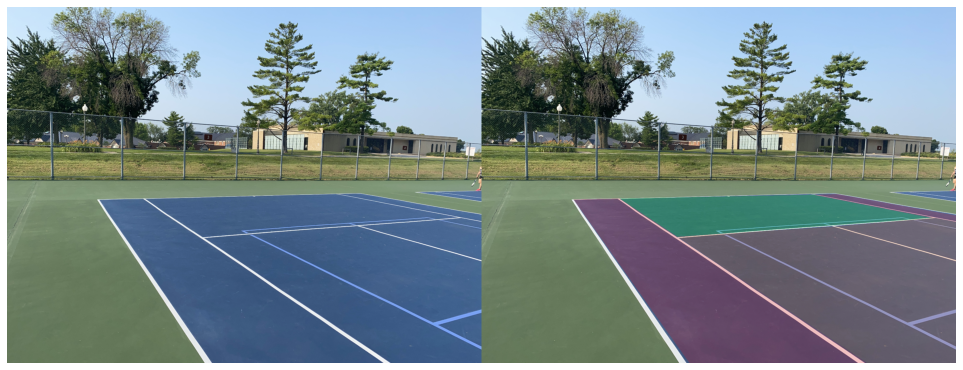

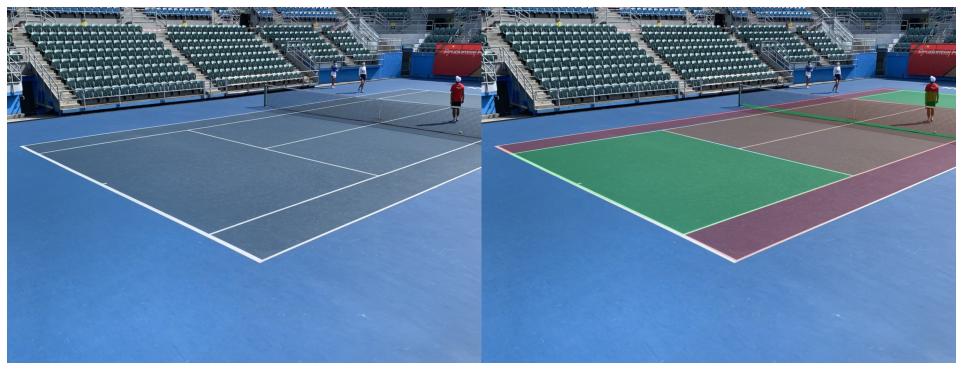

<Figure size 1224x504 with 0 Axes>

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

image_folder = 'tennis_court_images'

alpha = .8
buffer = 1
dilation = 5
min_angle = .1
max_line_gap = 2
hough_threshold = 100
new_image_height = 1149
min_line_distance = 380
max_number_of_lines = 50
canny_threshold0_end = 889
canny_threshold1_end = 319
canny_threshold0_start = 864
canny_threshold1_start = 278
starting_min_homography_error = 54
redundant_point_max_difference = 22
maximum_allowable_point_to_line_fulcrum_distance = 9
t_detection_maximum_allowable_point_to_line_distance = 9

def process_image(image):
    global detected_and_predicted
    
    homography_found = False
    min_homography_error = starting_min_homography_error
    rgb_image = cv2.cvtColor(cv2.imread(image_folder+'/'+image), cv2.COLOR_BGR2RGB)
    image_height, image_width, _ = rgb_image.shape
    rescale_factor = image_height/new_image_height
    rgb_image = cv2.resize(rgb_image, (int(image_width/rescale_factor), int(image_height/rescale_factor)))
    
    for canny_threshold0 in range(canny_threshold0_start, canny_threshold0_end):
        for canny_threshold1 in range(canny_threshold1_start, canny_threshold1_end):
            court_points = []
            detected_lines = cv2.HoughLinesP(cv2.dilate(cv2.Canny(cv2.cvtColor(rgb_image, cv2.COLOR_RGB2GRAY), canny_threshold0, canny_threshold1), np.ones((dilation, dilation))), 1, np.pi/180, hough_threshold, None, min_line_distance, max_line_gap)
            number_of_lines = len(detected_lines)

            if number_of_lines > 6 and number_of_lines < max_number_of_lines:
                for i in range(number_of_lines):
                    for j in range(i+1, number_of_lines):
                        line0 = detected_lines[i][0]
                        line1 = detected_lines[j][0]
                        line0_x0 = line0[0]
                        line0_x1 = line0[2]
                        line1_x0 = line1[0]
                        line1_x1 = line1[2]
                        line0_x_diff = line0_x1 - line0_x0
                        line1_x_diff = line1_x1 - line1_x0

                        if line0_x_diff != 0 and line1_x_diff != 0:
                            line0_y0 = line0[1]
                            line0_y1 = line0[3]
                            line1_y0 = line1[1]
                            line1_y1 = line1[3]
                            m0 = (line0_y1 - line0_y0)/line0_x_diff
                            m1 = (line1_y1 - line1_y0)/line1_x_diff
                            multiplied_slopes = m0*m1

                            if multiplied_slopes != -1:
                                angle = np.arctan((m1 - m0)/(1 + multiplied_slopes))

                                if abs(angle) > min_angle:
                                    b0 = line0_y0 - line0_x0*m0
                                    b1 = line1_y0 - line1_x0*m1

                                    for point_in_first_line in [True, False]:
                                        for first_point in [True, False]:
                                            if point_in_first_line:
                                                point_line = line0
                                                line_x0 = line1[0]
                                                line_y0 = line1[1]
                                                line_x1 = line1[2]
                                                line_y1 = line1[3]
                                                m = m1
                                                b = b1
                                            else:
                                                point_line = line1
                                                line_x0 = line0[0]
                                                line_y0 = line0[1]
                                                line_x1 = line0[2]
                                                line_y1 = line0[3]
                                                m = m0
                                                b = b0

                                            if first_point:
                                                point_x = point_line[0]
                                                point_y = point_line[1]
                                            else:
                                                point_x = point_line[2]
                                                point_y = point_line[3]

                                            if ((point_x > line_x0 - buffer and point_x < line_x1 + buffer) or (point_x > line_x1 - buffer and point_x < line_x0 + buffer)) and ((point_y > line_y0 - buffer and point_y < line_y1 + buffer) or (point_y > line_y1 - buffer and point_y < line_y0 + buffer)) and abs(point_y - point_x*m - b) < t_detection_maximum_allowable_point_to_line_distance:
                                                add_point = True

                                                for court_point in court_points:
                                                    if ((point_x - court_point['point_x'])**2 + (point_y - court_point['point_y'])**2)**.5 < redundant_point_max_difference:
                                                        add_point = False

                                                if add_point:
                                                    court_points.append({'point_x': point_x, 'point_y': point_y, 'm0': m0, 'm1': m1, 'b0': b0, 'b1': b1})

                if len(court_points) == 7:
                    fulcrum_point_index = 0
                    four_set_found = False

                    while fulcrum_point_index < 7 and not four_set_found:
                        slope0_court_point_indices = [fulcrum_point_index]
                        slope1_court_point_indices = [fulcrum_point_index]
                        four_points_on_line = []
                        three_points_on_line = []

                        for comparitor_index in range(7):
                            if fulcrum_point_index != comparitor_index:
                                if abs(court_points[fulcrum_point_index]['m0']*court_points[comparitor_index]['point_x'] + court_points[fulcrum_point_index]['b0'] - court_points[comparitor_index]['point_y']) < maximum_allowable_point_to_line_fulcrum_distance:
                                    slope0_court_point_indices.append(comparitor_index)

                                if abs(court_points[fulcrum_point_index]['m1']*court_points[comparitor_index]['point_x'] + court_points[fulcrum_point_index]['b1'] - court_points[comparitor_index]['point_y']) < maximum_allowable_point_to_line_fulcrum_distance:
                                    slope1_court_point_indices.append(comparitor_index)

                        if len(slope0_court_point_indices) == 4:
                            four_set_found = True

                            for i in range(7):
                                if i in slope0_court_point_indices:
                                    four_points_on_line.append(court_points[i])
                                else:
                                    three_points_on_line.append(court_points[i])        
                        elif len(slope1_court_point_indices) == 4:
                            four_set_found = True

                            for i in range(7):
                                if i in slope1_court_point_indices:
                                    four_points_on_line.append(court_points[i])
                                else:
                                    three_points_on_line.append(court_points[i])
                        else:          
                            fulcrum_point_index += 1

                        if four_set_found:
                            ordered_detected_points = [[point['point_x'], point['point_y']] for point in sorted(four_points_on_line, key=lambda point: point['point_x']) + sorted(three_points_on_line, key=lambda point: point['point_x'])]
                            known = [[0, 0], [1372, 0], [9601, 0], [10973, 0], [1372, 5486], [5486, 5486], [9601, 5486]]
                            npa_ordered_detected_points = np.array(ordered_detected_points)
                            h, _ = cv2.findHomography(np.array(known), npa_ordered_detected_points)
                            flattened_detected_points = npa_ordered_detected_points.flatten()
                            predict_known = np.array([point[0] for point in cv2.perspectiveTransform(np.array([[point] for point in known], dtype=float), h)]).flatten()
                            homography_error = 0

                            for i in range(len(predict_known)):
                                homography_error += abs(flattened_detected_points[i] - predict_known[i])

                            if homography_error < min_homography_error:
                                homography_found = True
                                print("Image Name: "+image+", Canny Threshold 0: "+str(canny_threshold0)+", Canny Threshold 1: "+str(canny_threshold1)+", Number of Lines: "+str(number_of_lines)+", Homography Error: "+str(round(homography_error, 1)))
                                min_homography_error = homography_error
                                detected_and_predicted = np.array(ordered_detected_points + [point[0] for point in cv2.perspectiveTransform(np.array([[point] for point in [[-700, 11887], [0, 11887], [1372, 11887], [5486, 11887], [9601, 11887], [10973, 11887], [11673, 11887], [1372, 18288], [5486, 18288], [9601, 18288], [0, 23774], [1372, 23774], [9601, 23774], [10973, 23774]]], dtype=float), h)], dtype=int)

    if homography_found:
        detection_image = rgb_image.copy()

        for back_rectangle in [[1, 2, 6, 4], [14, 16, 19, 18]]:
            back_rectangle_coordinates = np.array([detected_and_predicted[back_rectangle_index] for back_rectangle_index in back_rectangle])
            
            if all(coordinate > 0 for coordinate in back_rectangle_coordinates.flatten()):
                cv2.fillPoly(detection_image, [back_rectangle_coordinates], (0, 255, 0))
                
        for lane in [[0, 1, 9, 8], [8, 9, 18, 17], [2, 3, 12, 11], [11, 12, 20, 19]]:
            lane_coordinates = np.array([detected_and_predicted[lane_index] for lane_index in lane])

            if all(coordinate > 0 for coordinate in lane_coordinates.flatten()):
                cv2.fillPoly(detection_image, [lane_coordinates], (255, 0, 0))

        for front_squares in [[4, 5, 10, 9], [9, 10, 15, 14], [5, 6, 11, 10], [10, 11, 16, 15]]:
            front_square_coordinates = np.array([detected_and_predicted[front_square_index] for front_square_index in front_squares])

            if all(coordinate > 0 for coordinate in front_square_coordinates.flatten()):
                cv2.fillPoly(detection_image, [front_square_coordinates], (255, 100, 0))

        cv2.line(detection_image, (detected_and_predicted[7][0], detected_and_predicted[7][1]), (detected_and_predicted[13][0], detected_and_predicted[13][1]), (0, 255, 0), 10)
        plt.axis('off')
        plt.imshow(np.concatenate((rgb_image, cv2.addWeighted(rgb_image, alpha, detection_image, 1-alpha, 0)), axis=1))
        plt.figure()
    
plt.rcParams['figure.figsize'] = 17, 7
    
for image in os.listdir(image_folder):
    process_image(image)
